# Build an efficient unsupervised word translator

Based on : "Word Translation Without Parallel Data" by Alexis Conneau, Guillaume Lample, Marc Aurelio Ranzato, Ludovic Denoyer & Hervé Jégou (2017)

In this notebook we will explore Generative Adversarial Networks (GANs) for word translator. GANs belong to the set of algorithms named generative models. Generative models learn the intrinsic distribution function of the input words data p(x), allowing them to generate both synthetic inputs/sources x’ and output/targets y’.

## Data pre-processing

In [1]:
import io

import numpy as np
import matplotlib.pyplot as plt
import math

import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
#from torch.autograd.variable import Variable

from scipy.stats import special_ortho_group

#from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
# load function for pretrained versions of word embeddings
def load_embeddings(emb_path, nmax=50000):
    vectors = []
    word2id = {}
    with io.open(emb_path, 'r', encoding='utf-8', newline='\n', errors='ignore') as f:
        next(f)
        for i, line in enumerate(f):
            word, vect = line.rstrip().split(' ', 1)
            vect = np.fromstring(vect, sep=' ')
            assert word not in word2id, 'word found twice'
            vectors.append(vect)
            word2id[word] = len(word2id)
            if len(word2id) == nmax:
                break
    id2word = {v: k for k, v in word2id.items()}
    embeddings = np.vstack(vectors)
    return embeddings, id2word, word2id

# load ground-truth bilingual dictionaries function
def load_dic(path):
    dico_full = {}
    vectors_src=[]
    vectors_tgt = []
    with io.open(path,'r',encoding='utf_8') as f:
        for i,line in enumerate(f):
            word_src, word_tgt = line.rstrip().split(' ',1)
            if word_tgt in tgt_word2id :
                dico_full[word_src]=word_tgt
    for key in dico_full.keys() :
            vectors_src.append(src_embeddings[src_word2id[key]])
            vectors_tgt.append(tgt_embeddings[tgt_word2id[dico_full[key]]])
    X = np.vstack(vectors_src)
    Z = np.vstack (vectors_tgt)
    return dico_full,X,Z

In [3]:
eng_path = '/Users/minh/Downloads/CSE293_NLP-master/wiki.en.vec'
fr_path = '/Users/minh/Downloads/CSE293_NLP-master/wiki.fr.vec'

# load monolingual word embeddings 
src_embeddings, src_id2word, src_word2id = load_embeddings(fr_path, nmax) # source = french 
tgt_embeddings, tgt_id2word, tgt_word2id = load_embeddings(eng_path, nmax) # target = english

In [5]:
# train & test bilingual dictionaries

path_train = '/Users/minh/Downloads/CSE293_NLP-master/fr-en.0-5000.txt' 
path_test = '/Users/minh/Downloads/CSE293_NLP-master/fr-en.5000-6500.txt'

dico_train, X_train, Z_train = load_dic(path_train)
dico_test, X_test, Z_test = load_dic(path_test)

# convert embeddings vectors into torch tensors 
print(type(X_train[0]))
X_train, Z_train, X_test, Z_test = map(torch.tensor, (X_train, Z_train, X_test, Z_test)) 
print(type(X_train[0]))

<class 'numpy.ndarray'>
<class 'torch.Tensor'>


In [6]:
print(X_train.shape[0], "training samples")
print(X_test.shape[0], "test samples")
dim = X_train.shape[1]
print("Vectors dimension :", dim)

4971 training samples
1483 test samples
Vectors dimension : 300


# Coding GANs

## Build the discriminator 

Discriminator model’s goal is to recognize if an input data is ‘real’ y (target) — belongs to the original dataset — or if it is ‘fake’ Wx (source and translation matrix trained) — generated by a forger. 

In [7]:
class Discriminator(nn.Module):
    def __init__(self, dim):
        super(Discriminator,self).__init__()
        self.h1 = nn.Linear(dim, 2048,bias=True) # 1st hidden layer
        self.h2 = nn.Linear(2048,2048,bias=True) # 2nd hidden layer
        self.out = nn.Linear(2048,1,bias=True) # output layer
        
    def forward(self, x):
        x = F.dropout(x, p = 0.1) # dropout pour ajouter du bruit
        x = F.leaky_relu(self.h1(x), negative_slope=0.2)
        x = F.leaky_relu(self.h2(x), negative_slope=0.2)
        y = torch.sigmoid(self.out(x)) # ouput = proba
        return y

## Build the generator 

Generator aims to generate new data similar to the expected one.

In [9]:
# simple linear function 
# can be seen at a neural network whose weights are elements of W 
class Generator(nn.Module):
    def __init__(self, dim):
        super(Generator, self).__init__()
        self.l1 = nn.Linear(dim, dim)

    def forward(self,x):
        y = self.l1(x)
        return y

In [10]:
# we could put this inside the class...

# to ensure that the matrix stays close to the manifold of orthogonal matrices after each update
def ortho_update(W, beta):
    W = (1+beta)*W - beta*torch.mm(torch.mm(W, W.t()), W)

## Optimization

Here we’ll use SGD as the optimization algorithm for both neural networks, with a learning rate of 0.1. The proposed learning rate was obtained after testing with several values, though it isn’t necessarily the optimal value for this task. 

The loss function we’ll be using for this task is named Binary Cross Entopy Loss (BCE Loss)

<img src='https://miro.medium.com/max/5728/1*IcuF1_TXjngF2VHQjdwzjg.png'>

In [ ]:
discrim = Discriminator(dim) #Definie Discriminator and Generator
gen = Generator(dim)

optimD = optim.SGD(discrim.parameters(), lr=0.1)#Definie optimizer
optimG = optim.SGD(gen.parameters(), lr=0.1)

In [103]:
LossD = nn.BCELoss() #Definie loss function
LossG = nn.BCELoss()

# Trainning GANs 

Now that we’ve defined the dataset, networks, optimization and learning algorithms we can train our GAN. 

<img src='https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/05/Summary-of-the-Generative-Adversarial-Network-Training-Algorithm.png'>

In [50]:
#for epoch in range(3): #3 Epochs 
W_train = []
N = 32 # nb of "fake" tgt // Wx
M = 32 # nb of "true" tgt // y

W = special_ortho_group.rvs(dim) # initialisation of W in SO(300)
W = torch.tensor(W,dtype=torch.float) # conversion to tensor
beta = 0.01

# ini the weights of the discrim
for p in discrim.parameters():
    p.data = torch.zeros(p.data.shape)

niter = 10000
for iteration in range(niter):
    if iteration % 10 == 0 :
        print("epoch = %d, iteration = %d"%(1,iteration))
    
    # 1. DISCRIMINATOR TRAINING
    for i in range(3):
        # set the discrimintator training mode to True
        discrim.train()
        
        # set descrim gradient to zero before computation at every step
        optimD.zero_grad()
        
        ## create a new batch of N fake & M true data to train the discriminator
        # generate 32 random words from the source 
        rand_src_word_id = torch.Tensor(N).random_(nmax).long()
        src_word_emb = src_embeddings[rand_src_word_id.numpy()]
        src_word_emb = torch.tensor(src_word_emb, dtype=torch.float) # conversion to tensor
    
        wsrc_gen = gen(src_word_emb) # translated words (Wx)
    
        # generate 32 random words from the target
        rand_tgt_word_id = torch.Tensor(M).random_(nmax).long()
        tgt_word_emb = tgt_embeddings[rand_tgt_word_id.numpy()]
        tgt_word_emb = torch.tensor(tgt_word_emb, dtype=torch.float) # conversion to tensor

        # concatenation of Wx and y aka traductions and tgt words
        input_tensor = torch.cat([wsrc_gen, tgt_word_emb],0)

        # output tensor is the answer the discriminator should give
        output_tensor = torch.Tensor(64).zero_().float()
        # we can smooth the answer by creating thresholds (# 0.8 # smoothing 80% # smoothing 20%)
        output_tensor[:N] = 1 # discrim should predict 100% proba of belonging to the src 
        output_tensor[N:] = 0 # discrim should predict 100% proba of belonging to the tgt 
        
        # prediction of the discriminator
        prediction = discrim(input_tensor)
        
        # compute loss & propogate backward
        loss_discrim = LossD(prediction, output_tensor)
        # loss_discrim = LossDisc(output_tensor, prediction)
        
        loss_discrim.backward()
        optimD.step()

    # 2. GENERATOR TRAINING
    
    # set the discrimintator training mode to False 
    discrim.eval()
    
    # set descrim gradient to zero before computation at every step
    optimG.zero_grad()
    
    ## create a new batch of N fake & M true data to train the generator
    # generate 32 random words from the source 
    rand_src_word_id = torch.Tensor(N).random_(nmax).long()
    src_word_emb = src_embeddings[rand_src_word_id.numpy()]
    src_word_emb = torch.tensor(src_word_emb, dtype=torch.float) # conversion to tensor

    wsrc_gen = gen(src_word_emb) # translated words (Wx)

    # generate 32 random words from the target
    rand_tgt_word_id = torch.Tensor(M).random_(nmax).long()
    tgt_word_emb = tgt_embeddings[rand_tgt_word_id.numpy()]
    tgt_word_emb = torch.tensor(tgt_word_emb, dtype=torch.float) # conversion to tensor    
    
    # concatenation of Wx and y aka traductions and tgt words
    input_tensor = torch.cat([wsrc_gen, tgt_word_emb],0)
    
    # output tensor is the answer the discriminator should give
    output_tensor = torch.Tensor(64).zero_().float()
    # we can smooth the answer by creating thresholds (# 0.8 # smoothing 80% # smoothing 20%)
    output_tensor[:N] = 1 # discrim should predict 100% proba of belonging to the src 
    output_tensor[N:] = 0 # discrim should predict 100% proba of belonging to the tgt 
      
    # prediction of the discriminator on the new batch
    prediction = discrim(input_tensor)

    # compute loss & propogate backward
    # the discriminator is fooled if he predicts the contrary of what he should have predicted
    loss_gen = LossG(prediction, 1-output_tensor)
    # loss_gen = LossGen(1-output_tensor, prediction)

    loss_gen.backward()
    optimG.step()    

    W_trained = gen.l1.weight.data # get the weights of the generator which are the elements of W
    W_ortho = ortho_update(W_trained, beta)
    if iteration%50 ==0 :
        W_train.append(W_trained)
        print(iteration)

epoch = 1, iteration = 0
0


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


epoch = 1, iteration = 10
epoch = 1, iteration = 20
epoch = 1, iteration = 30
epoch = 1, iteration = 40
epoch = 1, iteration = 50
50
epoch = 1, iteration = 60
epoch = 1, iteration = 70
epoch = 1, iteration = 80
epoch = 1, iteration = 90
epoch = 1, iteration = 100
100
epoch = 1, iteration = 110
epoch = 1, iteration = 120
epoch = 1, iteration = 130
epoch = 1, iteration = 140
epoch = 1, iteration = 150
150
epoch = 1, iteration = 160
epoch = 1, iteration = 170
epoch = 1, iteration = 180
epoch = 1, iteration = 190
epoch = 1, iteration = 200
200
epoch = 1, iteration = 210
epoch = 1, iteration = 220
epoch = 1, iteration = 230
epoch = 1, iteration = 240
epoch = 1, iteration = 250
250
epoch = 1, iteration = 260
epoch = 1, iteration = 270
epoch = 1, iteration = 280
epoch = 1, iteration = 290
epoch = 1, iteration = 300
300
epoch = 1, iteration = 310
epoch = 1, iteration = 320
epoch = 1, iteration = 330
epoch = 1, iteration = 340
epoch = 1, iteration = 350
350
epoch = 1, iteration = 360
epoch = 1,

epoch = 1, iteration = 2880
epoch = 1, iteration = 2890
epoch = 1, iteration = 2900
2900
epoch = 1, iteration = 2910
epoch = 1, iteration = 2920
epoch = 1, iteration = 2930
epoch = 1, iteration = 2940
epoch = 1, iteration = 2950
2950
epoch = 1, iteration = 2960
epoch = 1, iteration = 2970
epoch = 1, iteration = 2980
epoch = 1, iteration = 2990
epoch = 1, iteration = 3000
3000
epoch = 1, iteration = 3010
epoch = 1, iteration = 3020
epoch = 1, iteration = 3030
epoch = 1, iteration = 3040
epoch = 1, iteration = 3050
3050
epoch = 1, iteration = 3060
epoch = 1, iteration = 3070
epoch = 1, iteration = 3080
epoch = 1, iteration = 3090
epoch = 1, iteration = 3100
3100
epoch = 1, iteration = 3110
epoch = 1, iteration = 3120
epoch = 1, iteration = 3130
epoch = 1, iteration = 3140
epoch = 1, iteration = 3150
3150
epoch = 1, iteration = 3160
epoch = 1, iteration = 3170
epoch = 1, iteration = 3180
epoch = 1, iteration = 3190
epoch = 1, iteration = 3200
3200
epoch = 1, iteration = 3210
epoch = 1, it

5700
epoch = 1, iteration = 5710
epoch = 1, iteration = 5720
epoch = 1, iteration = 5730
epoch = 1, iteration = 5740
epoch = 1, iteration = 5750
5750
epoch = 1, iteration = 5760
epoch = 1, iteration = 5770
epoch = 1, iteration = 5780
epoch = 1, iteration = 5790
epoch = 1, iteration = 5800
5800
epoch = 1, iteration = 5810
epoch = 1, iteration = 5820
epoch = 1, iteration = 5830
epoch = 1, iteration = 5840
epoch = 1, iteration = 5850
5850
epoch = 1, iteration = 5860
epoch = 1, iteration = 5870
epoch = 1, iteration = 5880
epoch = 1, iteration = 5890
epoch = 1, iteration = 5900
5900
epoch = 1, iteration = 5910
epoch = 1, iteration = 5920
epoch = 1, iteration = 5930
epoch = 1, iteration = 5940
epoch = 1, iteration = 5950
5950
epoch = 1, iteration = 5960
epoch = 1, iteration = 5970
epoch = 1, iteration = 5980
epoch = 1, iteration = 5990
epoch = 1, iteration = 6000
6000
epoch = 1, iteration = 6010
epoch = 1, iteration = 6020
epoch = 1, iteration = 6030
epoch = 1, iteration = 6040
epoch = 1, it

epoch = 1, iteration = 8540
epoch = 1, iteration = 8550
8550
epoch = 1, iteration = 8560
epoch = 1, iteration = 8570
epoch = 1, iteration = 8580
epoch = 1, iteration = 8590
epoch = 1, iteration = 8600
8600
epoch = 1, iteration = 8610
epoch = 1, iteration = 8620
epoch = 1, iteration = 8630
epoch = 1, iteration = 8640
epoch = 1, iteration = 8650
8650
epoch = 1, iteration = 8660
epoch = 1, iteration = 8670
epoch = 1, iteration = 8680
epoch = 1, iteration = 8690
epoch = 1, iteration = 8700
8700
epoch = 1, iteration = 8710
epoch = 1, iteration = 8720
epoch = 1, iteration = 8730
epoch = 1, iteration = 8740
epoch = 1, iteration = 8750
8750
epoch = 1, iteration = 8760
epoch = 1, iteration = 8770
epoch = 1, iteration = 8780
epoch = 1, iteration = 8790
epoch = 1, iteration = 8800
8800
epoch = 1, iteration = 8810
epoch = 1, iteration = 8820
epoch = 1, iteration = 8830
epoch = 1, iteration = 8840
epoch = 1, iteration = 8850
8850
epoch = 1, iteration = 8860
epoch = 1, iteration = 8870
epoch = 1, it

# Result

In [19]:
# 2 possibles functions of accuracy = 
# - Test if we traduced well the word = sum Indicatrice(Wxi!=zi) (en gros nb de mots mal traduits) # en fait non c'est con on a pas les traductions
# - Test how far we are from the "supposed" translation
# compute Wxi find the closest z (SUPPOSED TO BE ITS TRANSLATION) and cumpute eculidian distance

rand_test_word_id = torch.Tensor(30).random_(nmax).long()
X_test = src_embeddings[rand_test_word_id.numpy()] # GARDER LES MEMES POUR LES TESTS

def test_accuracy(X_text,W_trained):
    loss = 0
    for x in X_test : #get all french words
        word2id = {v: k for k, v in src_id2word.items()}
        word_emb_new = np.dot(W_trained,x)
        scores = (tgt_embeddings / np.linalg.norm(tgt_embeddings, 2, 1)[:, None]).dot(word_emb_new / np.linalg.norm(word_emb_new))
        best = scores.argsort()[-1:][::-1]
        nearest_eng_emb = src_embeddings[best]
        loss = loss + np.linalg.norm(word_emb_new-nearest_eng_emb)  
    return(loss)
    
#Pous savoir si le model est pertinent tester l'accuracy pour W_trained a epoch 1,5,10
                             

In [108]:
print('Loss function is ', test_accuracy(X_test,W_trained)) #same result for iter = 10k or 250

Loss function is  175.72820480497134


## Word translator Visualization

In [39]:
import sklearn
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import random

def prediction(W, new_word, k=5):
    x = src_embeddings[src_word2id[new_word]] # vector representation of new_word in the source space
    z = np.dot(W, x) # vector representation of the translated word in the target space

    # representation closest to z in the target language space, using cosine similarity as the distance metric
    z_pred1 = np.argmax(sklearn.metrics.pairwise.cosine_similarity(z.reshape(1,300),tgt_embeddings))

    # top k closest word embeddings in the target space
    z_predk = sklearn.metrics.pairwise.cosine_similarity(z.reshape(1,300),tgt_embeddings)[0].argsort()[-k:][::-1]
    
    return [tgt_id2word[z_pred1]], [tgt_id2word[z_predk[i]] for i in range(len(z_predk))]

In [89]:
#src_words = random.sample(list(src_word2id.keys()), 10)
src_words = ['bateau', 'maison', 'argent', 'ordinateur', 'dieu']
tgt_words = []
for i in range(0,len(src_words)):
    top1, top5 = prediction(W_trained.numpy(), src_words[i], k=5) #top 1: english word (target)
    tgt_words.append(top1[0])
    print(top5)
    print('--')

['compositions', 'scandals', 'compromising', 'operas', 'pop']
--
['seminaries', 'seminary', 'vocation', 'evangelicals', 'cartels']
--
['yourself', 'incorporate', 'chabad', 'create', 'serve']
--
['payoff', 'combines', 'uses', 'roulette', 'surprise']
--
['leverage', 'willingness', 'opportunity', 'newfound', 'restrain']
--


Variance explained: 0.10


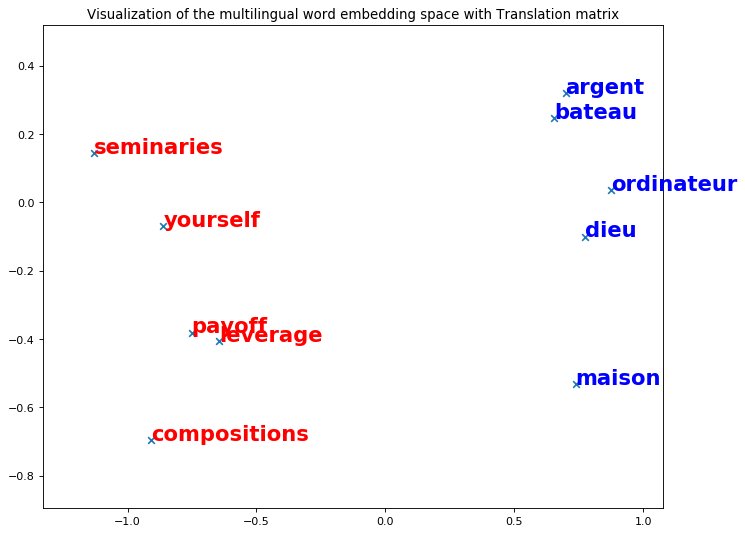

In [47]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, whiten=True)  # TSNE(n_components=2, n_iter=3000, verbose=2)
pca.fit(np.vstack([src_embeddings, tgt_embeddings]))
print('Variance explained: %.2f' % pca.explained_variance_ratio_.sum())

import matplotlib.pyplot as plt


def plot_similar_word(src_words, src_word2id, src_emb, tgt_words, tgt_word2id, tgt_emb, pca):

    Y = []
    word_labels = []
    for sw in src_words:
        Y.append(src_emb[src_word2id[sw]])
        word_labels.append(sw)
    for tw in tgt_words:
        Y.append(tgt_emb[tgt_word2id[tw]])
        word_labels.append(tw)

    # find tsne coords for 2 dimensions
    Y = pca.transform(Y)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]

    # display scatter plot
    plt.figure(figsize=(10, 8), dpi=80)
    plt.scatter(x_coords, y_coords, marker='x')

    for k, (label, x, y) in enumerate(zip(word_labels, x_coords, y_coords)):
        color = 'blue' if k < len(src_words) else 'red'  # src words in blue / tgt words in red
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontsize=19,
                     color=color, weight='bold')

    plt.xlim(x_coords.min() - 0.2, x_coords.max() + 0.2)
    plt.ylim(y_coords.min() - 0.2, y_coords.max() + 0.2)
    plt.title('Visualization of the multilingual word embedding space with Translation matrix')

    plt.show()
    
plot_similar_word(src_words, src_word2id, src_embeddings, tgt_words, tgt_word2id, tgt_embeddings, pca)


## Calculation of accuracy

In [94]:
# measure of the accuracy of the dictionnary
# output is a list
def accuracy(dpred1, dpredk, dico):
    acc1 = [0]
    acck = [0]
    
    for key in dico.keys():
        add1, addk = 0, 0
        
        if dico[key] == dpred1[key][0]:
            add1 = 1
        acc1.append(acc1[-1] + add1)  
    
        for i in np.arange(k):
            if dico[key] == dpredk[key][i]:
                addk = 1
                break   
        acck.append(acck[-1] + addk) 
    
    acc1 = [i/len(dico) for i in acc1]   
    acck = [i/len(dico) for i in acck]
    
    return acc1, acck # nb de mots bien prédits/nb de mots total   

# construct a translation French to English dictionary
def prediction_dict(dico, W, kk):
    dico_pred1 = {}
    dico_predk = {}
    i = 0
    for word in dico.keys() :
        if (i%100==0):
            print("Progress :", round(i/len(dico_test)*100,1), "%")
        dico_pred1[word], dico_predk[word] = prediction(W, word, k) # lists
        i += 1
    print("Done...")
    return dico_pred1, dico_predk

In [96]:
k = 5

dico_pred1, dico_predk = prediction_dict(dico_test, zik, k) 

Progress : 0.0 %
Progress : 6.7 %
Progress : 13.5 %
Progress : 20.2 %
Progress : 27.0 %
Progress : 33.7 %
Progress : 40.5 %
Progress : 47.2 %
Progress : 53.9 %
Progress : 60.7 %
Progress : 67.4 %
Progress : 74.2 %
Progress : 80.9 %
Progress : 87.7 %
Progress : 94.4 %
Done...


NameError: name 'Wmin' is not defined

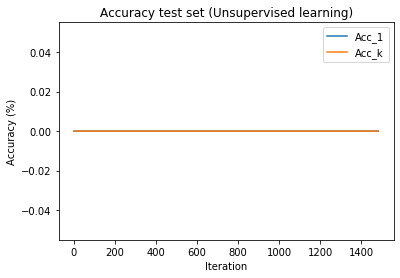

In [102]:
acc1_test, acck_test = accuracy(dico_pred1, dico_predk, dico_test)
plt.plot(acc1_test, label="Acc_1")
plt.plot(acck_test,label="Acc_k")
plt.ylabel('Accuracy (%)')
plt.xlabel('Iteration')
plt.title("Accuracy test set (Unsupervised learning)")
plt.legend()
plt.show()